# Heated Pipe System with Heat Loss

This tutorial describes the process of controlling the outlet temperature of a 300 meters heat pipe close to the 
boiling temperature.

The main goal is to describe the process of solving rather than the details of the equations.

---
## 1. System Description

The system consists of a 300m circular pipe through which water flows continuously. A heater is connected at the entrance ($x = 0$) 
of the pipe, providing a constant power input $P$ to the water. The water flows with constant velocity $u$, losing heat 
to the environment due to convection. At the outlet, the water returns to the heater, creating a closed loop.

![heat loop](simple_diagram.png)

The goal is to perform a bacteria decontamination of the loop, requiring a temperature of at least 85°C through the loop
with a 2°C/min ascent and without creating steam in the pipe.

***How to ensure $T_{outlet}$>85°C and $T_{inlet}$<95°C ? Can we control the heating speed precisely to 2°C/min?***

### First findings, why is it tricky?

Following plot shows what happens when the system is heated at a constant 30kW power which is barely the maximum power :

![heat loop](step_response.jpg)

From this we observe :
- Stair-like behavior due to the recirculation of water
- An inlet temperature that can go close to 100°C despite an outlet temperature that is barely above 85°C
- A significant delay (~12 min)
- A coupling and an intrication between inlet and outlet temperature

**How to model and simulate these stairs?**

### Naive model

[//]: # (The PDE equation can be naively discretized as follows:)

[//]: # (- The pipe is divided in N discrete segments)

[//]: # (- For each segment, its temperature is obtained by averaging its temperature with the neighbors and with the surrounding )

[//]: # (environment,subject to the heat loss coefficient.)

[//]: # (- Each temperature value is transferred to the next segment)

Following simulation divides the pipe into small segments to model heat transfer step by step. At each time step, every segment’s 
temperature is updated based on its neighbors and the environment (using a heat loss coefficient), while the temperature at the pipe’s end is "pushed forward" 
to the start—like a wave of heat moving through. The heater at one end injects warmth, and the animation reveals how heat spreads, 
stabilizes, and flows through the system.

![heat loop](pipe_simulation.gif)

This gives a first approximation and intuition on the system to explain the stairs and the impact of losses on the heating curve.

Detailed plots in Appendix show the impact of heat loss coefficient and external temperature on the curves.

## Physical model equations:

The system schematic is shown below:

![heat loop](heat_loop.png)

The evolution of the temperature in the pipe is governed by the following partial differential equation (PDE) obtained by 
writing the energy balance equation of a pipe infinitesimal segment:

$$
\frac{\partial T}{\partial t} + u \frac{\partial T}{\partial x} = -\frac{h P_{\text{pipe}}}{\rho S c_p} \left[ T(x, t) - T_{\text{ext}} \right]
$$

All notations are detailed in Appendix.

To include the heater power in the equations, we can write the energy balance of the heater using 
$ \Theta_{\text{inlet}}(t) = T_{\text{inlet}} - T_{\text{ext}} $ and $\Theta_{\text{outlet}}(t) = T_{\text{outlet}} - T_{\text{ext}}$.
This allows to write the following Delayed Equations in which $\tau$ is the time of travel, $P$ the power of the heater, and $K<1$ the loss coefficient:

$$
\Theta_{\text{inlet}}(t) = \frac{P}{\dot{m}c_p} + K \Theta_{\text{inlet}}(t - \tau),
\Theta_{\text{outlet}}(t) = K \left( \frac{P}{\dot{m} c_p} +  \Theta_{\text{outlet}}(t - \tau) \right).
$$

What these equations say :
- A pipe segment always sees the water from one turn past, which temperature is modulated by the losses
- From an energy point of view, the system adds to the loop the amount of energy contained by the water inside the heater 
- Effect of the power is inversely scaled by the flow $\dot{m}$ which directly affects system properties



## 2. System Simulation


In [1]:
from simulation_backend import *
interact(
    simulate_and_plot,
    P=FloatSlider(min=1, max=33, step=0.5, value=10, description='Power (kW):')
);

interactive(children=(FloatSlider(value=10.0, description='Power (kW):', max=33.0, min=1.0, step=0.5), Output(…

In [5]:
from PI_backend import *

# Interactive sliders for tuning Kp, Ki, and T_ext
interact(
    simulate_PI,
    Kp=FloatSlider(min=0, max=2000, step=50, value=1500, description="Kp [W/°C]"),
    Ki=FloatSlider(min=0, max=0.5, step=0.025
                   , value=0.01, description="Ki [W/(°C·s)]"),
    T_ext=FloatSlider(min=0, max=40, step=1, value=20, description="T_ext (°C)"),
);



interactive(children=(FloatSlider(value=1500.0, description='Kp [W/°C]', max=2000.0, step=50.0), FloatSlider(v…

With correct tuning of the coefficients:

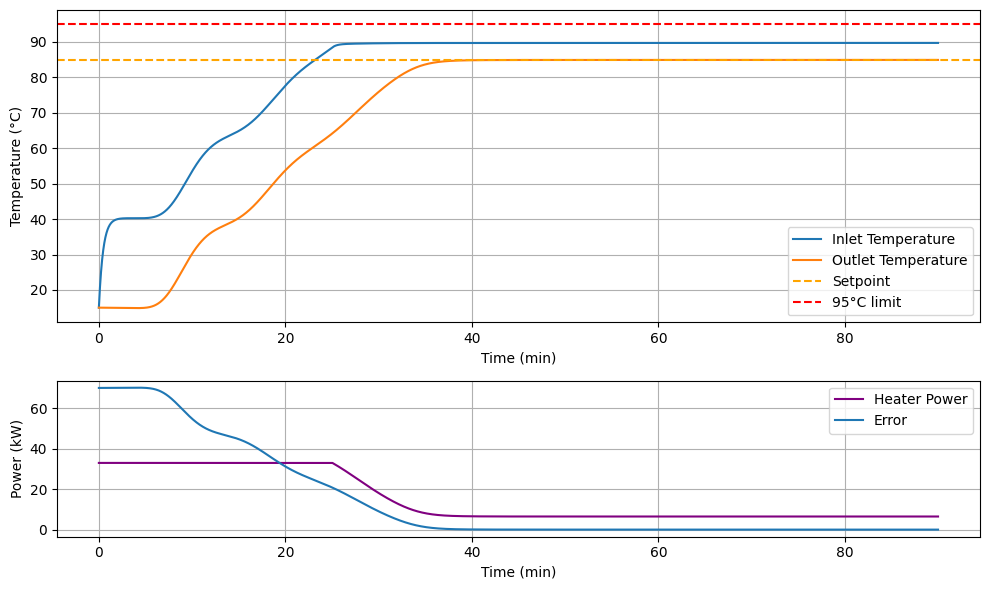

In [11]:
simulate_PI(Kp=1300,Ki=0.08,T_ext=10,);


## 3. Control

### Control Objectives

### 1) Traditionnal control technique with tinkering

The standard equation of the PI controller is:

$$
u(t) = K_p \, e(t) + K_i \int_0^t e(\tau) \, d\tau,
$$

where:
- u(t) is the power of the heater,
- $K_p$ is the proportional gain,
- $K_i$ is the integral gain,
- e(t) is the error between the setpoint and the outlet temperature.


### 2) Optimal control via MPC


$$
u^*(k) = \min_{u(0), \dots, u(N_p-1)}
\sum_{i=0}^{N_p-1} \left( y_i - (r_i - d_i) \right)^T Q \left( y_i - (r_i - d_i) \right) + u_i^T R u_i + \Delta u_i^T S \Delta u_i,
$$
$$
\text{subject to:}
\begin{align*}
&\mathbf{x}(0) = \mathbf{x}_0, \\
&\mathbf{x}_{i+1} = A \mathbf{x}_i + B u_i, \quad i = 0, \dots, N_p-1, \\
&y_i = C \mathbf{x}_i, \quad i = 0, \dots, N_p-1, \\
&0 \leq \mathbf{x}_i \leq 95, \quad i = 1, \dots, N_p, \\
&0 \leq u_i \leq 33, \quad i = 0, \dots, N_p-1, \\
&\Delta u_i = u(i) - u(i-1), \quad i = 1, \dots, N_p-1, \\
&0 \leq \Delta{u}_i \leq \Delta{u}_{max}, \quad i = 0, \dots, N_p-1, \\
&Q \succ 0, \, R \succ 0.
\end{align*}
$$

where:
- $N_p$ is the prediction horizon.
- $r_i$ is the moving reference at time $i$.
- $d_i$ is the moving disturbance ($T_{ext}$) at time $i$.
- $Q \succ 0$ and $R \succ 0$ are weighting matrices for output tracking and input usage, respectively.


### 3) Reinforcement Learning

## Comparison and conclusion

### Performances

### Security

### Complexity


### Conclusion



# Appendix

- $x$: Position along the pipe in **meters (m)**.
- $t$: Time in **seconds (s)**.
- $T(x, t)$: Temperature of water at position $x$ and time $t$ in **kelvin (K)**.
- $u$: Fluid velocity in **meters per second (m/s)**.
- $\rho$: Density of water in **kilograms per cubic meter (kg/m³)**.
- $c_p$: Specific heat capacity of water in **joules per kilogram-kelvin (J/(kg·K))**.
- $S$: Cross-sectional area of the pipe in **square meters (m²)**.
- $P_{\text{pipe}}$: Perimeter of the pipe in **meters (m)**.
- $h$: Convective heat transfer coefficient in **watts per square meter-kelvin (W/(m²·K))**.
- $P$: Heater power input in **watts (W)**.
- $K = e^{-\frac{\alpha \tau}{2}}$: A factor representing the effect of time delay and thermal losses (dimensionless).
- $\tau$: Delay time in **seconds (s)**.
- $\alpha$: Heat loss coefficient in **per second (1/s)**.

